In [ ]:
!pip install keras-unet-collection
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import random

import cv2
from PIL import Image, ImageOps

from tensorflow import keras
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import zipfile
import shutil
import json
import torch
import torchvision
import numpy as np
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import pandas as pd

from IPython.display import Image, display

import re
import pickle
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from tensorflow.python.client import device_lib

from keras_unet_collection import models, base, utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path ='/content/drive/MyDrive/plant.v4-574-574-with-weed.coco-segmentation.zip'

extract_path = '/content/dataset'
set1_path = '/content/set1'
set1_trimap='/content/trimap'

# 2. ZIP 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 3. 새로운 폴더 set1 생성 및 train/valid/test 폴더 생성
os.makedirs(set1_path, exist_ok=True)
for folder in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(set1_path, folder), exist_ok=True)
    os.makedirs(os.path.join(set1_trimap, folder), exist_ok=True)

In [ ]:
# 4. 동의나물 곰취 이미지를 새로운 폴더로 이동
def move_images_and_create_annotations(folder):
    src_images_path = os.path.join(extract_path, folder)
    dst_images_path = os.path.join(set1_path, folder)

    # JSON 파일 불러오기
    json_file_path = os.path.join(src_images_path, '_annotations.coco.json')
    with open(json_file_path, 'r', encoding='utf-8') as f:
        annotations = json.load(f)

    new_annotations = {
        "images": [],
        "annotations": [],
        "categories": annotations["categories"]
    }

    for image_info in annotations["images"]:
        image_name = image_info["file_name"]
        if "Donguinamul" in image_name or "Gomchwi" in image_name:
            # 이미지 파일 이동
            src_image = os.path.join(src_images_path, image_name)
            dst_image = os.path.join(dst_images_path, image_name)
            shutil.move(src_image, dst_image)

            # 이미지 정보 저장
            new_annotations["images"].append(image_info)

            # 이미지와 연관된 어노테이션 저장
            for annotation in annotations["annotations"]:
                if annotation["image_id"] == image_info["id"]:
                    new_annotations["annotations"].append(annotation)

    # 새로운 JSON 파일 생성
    new_json_file_path = os.path.join(dst_images_path, '_annotations.coco.json')
    with open(new_json_file_path, 'w', encoding='utf-8') as f:
        json.dump(new_annotations, f, ensure_ascii=False, indent=4)

# train/valid/test 폴더 처리
for folder in ['train', 'valid', 'test']:
    move_images_and_create_annotations(folder)

In [ ]:
with open('/content/set1/train/_annotations.coco.json') as f:
    coco_data = json.load(f)
annotations = coco_data['annotations']
images = {img['id']: img for img in coco_data['images']}

In [ ]:
li=[]
for det in ['train', 'valid', 'test']:
  with open(f'/content/set1/{det}/_annotations.coco.json') as f:
      coco_data = json.load(f)
  for i in coco_data['images']:
    li.append(((i['file_name'].split('_-_')[0]).split('-')[0]).split('_')[0])
  # result = [name.split('-')[0].split('_')[0] for name in li]
  li = list(set(li))
  name2label = {}
  for idx,i in enumerate(li):
    name2label[i] =idx+2

name2label


{'Gomchwi': 2, 'Donguinamul': 3}

In [ ]:
a='Gomchwi-Flower_-_-_905769_jpg.rf.27dbc9f62d01de4cedfd982c7990f65b.jpg'
name2label[((a.split('_-_')[0]).split('-')[0]).split('_')[0]]

2

In [ ]:
def create_trimap(folder):
    src_images_path = os.path.join('/content/set1', folder)
    dst_images_path = os.path.join('/content/trimap', folder)

    json_file_path = os.path.join(src_images_path, '_annotations.coco.json')
    with open(json_file_path, 'r', encoding='utf-8') as f:
        annotations = json.load(f)
    img_id = {}
    for i in annotations['images']:
      img_id[i['id']] = i['file_name']
    id_seg = {}
    for i in annotations['annotations']:
      if i['image_id'] in id_seg.keys():
        id_seg[i['image_id']].extend([i['segmentation']])
      else:
        id_seg[i['image_id']] = [i['segmentation']]
    id_bbox = {}
    for i in annotations['annotations']:
      if i['image_id'] in id_bbox.keys():
        id_bbox[i['image_id']].extend([i['bbox']])
      else:
        id_bbox[i['image_id']] = [i['bbox']]
    for image_id,file_name in img_id.items():
      trimap = np.zeros((574, 574), dtype=np.uint8)
      if image_id in id_seg:
          # for annotation in categori_dic[image_id]:
          segmentation = id_seg[image_id]
          tmp_color = name2label[((img_id[image_id].split('_-_')[0]).split('-')[0]).split('_')[0]]

              # 각 segmentation 데이터를 순회하며 다각형 그리기
          for polygon in segmentation:
              polygon_np = np.array(polygon, dtype=np.int32).reshape((-1, 2))

                  # 전경 (foreground)을 tmp_color로 채우기
              mask = np.zeros_like(trimap)
              cv2.fillPoly(mask, [polygon_np], tmp_color)
              trimap[mask == 1] = tmp_color

                      # 불확실한 영역을 위해 폴리곤의 외곽선 그리기
          cv2.polylines(trimap, [polygon_np], isClosed=True, color=1, thickness=8)  # 불확실한 영역의 두께를 조절 가능
      # if image_id in id_bbox:
      #   for bbox in id_bbox[image_id]:  # bbox_info가 bounding box 정보를 담고 있다고 가정
      #       x,y,w,h = bbox  # bounding box 좌표를 가져옴
      #       x_min =int(x)
      #       x_max = int(x + w)
      #       y_min = int(y)
      #       y_max =int( y +h)
      #       cv2.rectangle(trimap, (x_min, y_min), (x_max, y_max), color=tmp_color, thickness=2)  # bbox를 그리 bbox에 대한 라벨로 사용
      output_file = os.path.join(dst_images_path, file_name)
      cv2.imwrite(output_file, trimap)
for folder in ['train', 'valid', 'test']:
    create_trimap(folder)





In [ ]:
train_input_img_path = []
test_input_img_path = []
valid_input_img_path = []
target_train=[]
target_test=[]
target_valid =[]
det = ['train','test','valid']
for i in det:
  path = os.path.join('/content/set1',i)
  tri_path = os.path.join('/content/trimap',i)
  path_li=[]
  for j in os.listdir(path):
    if j.endswith('jpg'):
      name = os.path.join(path,j)
      trimap = os.path.join(tri_path,j)
      if i =='train':
        train_input_img_path.append(name)
        target_train.append(trimap)
      elif i=='test':
        test_input_img_path.append(name)
        target_test.append(trimap)
      else:
        valid_input_img_path.append(name)
        target_valid.append(trimap)



In [ ]:
img = image.load_img('/content/trimap/train/Donguinamul-WholePlant_-_156_jpg.rf.ff92e83af06794b97ffaac96b75e8bd2.jpg')
img_array = np.array(img)
print("Min value in image:", np.min(img_array))
print("Max value in image:", np.max(img_array))

Min value in image: 0
Max value in image: 2


In [ ]:
li=[]
# # # 고유한 값들을 세트에 저장
# # unique_values = set(flattened_array)
# # unique_values
for i in target_train:
  a =image.load_img(i)
  a= np.array(a)
  flattened_array = np.array(a,dtype=np.uint8).flatten()
  unique_values = set(flattened_array)
  if len(unique_values) >10:
    li.append(len(unique_values))
li

[]

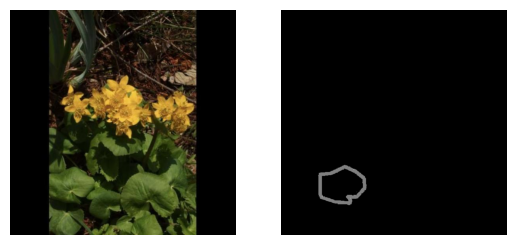

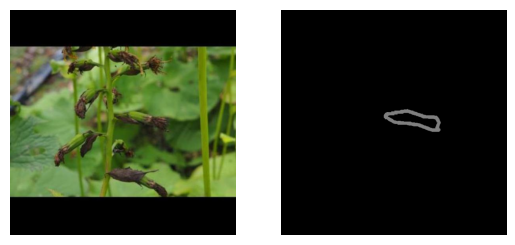

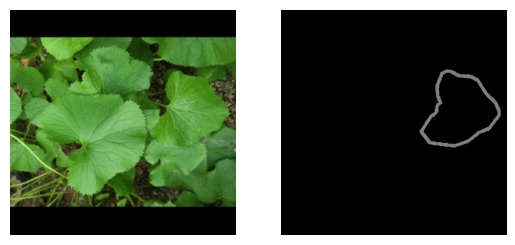

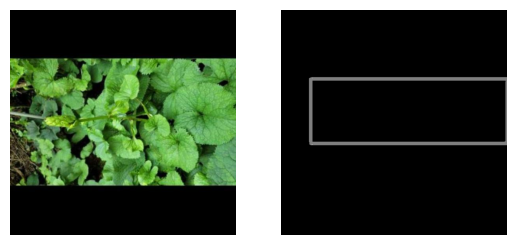

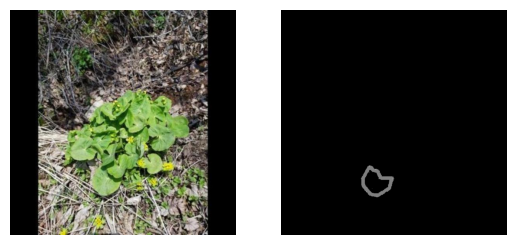

In [ ]:
## 여러 데이터 확인
for img_idx in range(5):
    rand_idx = random.randint(0, len(train_input_img_path))
    ori_img = image.load_img(train_input_img_path[rand_idx])
    target_img = ImageOps.autocontrast(image.load_img(target_train[rand_idx]))

    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(ori_img)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(target_img, vmax = 3, vmin = 0)
    plt.show()

In [ ]:
class PlantData(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, name2label):
        '''
        name2label : bread name -> species label : 1(cat), 2(dog)
        '''
        super().__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

        ##############################
        self.name2label= name2label

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """
        arg : batch idx
        Return : tuple (input img, target img) correspond to batch idx
        """
        ##############################
        prep = lambda x :((x.split('_-_')[0]).split('-')[0]).split('_')[0]
        ##############################

        i = idx * self.batch_size

        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = image.load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = image.load_img(path, target_size=self.img_size, color_mode="grayscale")
            ##############################
            img_arr = np.array(img)

            filename = os.path.basename(path).split('.')[0] # filename, ext
            label_idx = self.name2label[prep(filename)] # label_idx : 1 to23

            img_arr[img_arr == 0] = 0 # 0(background) -> 0
            img_arr[(img_arr == 1)] = label_idx # 1외곽선 -> label_idx:
            y[j] = np.expand_dims(img_arr, 2)
            ##############################

        return x, y


In [ ]:
batch_size = 4
img_size = (512,512)

train_gen = PlantData(batch_size, img_size, train_input_img_path, target_train, name2label)
val_gen = PlantData(batch_size, img_size, valid_input_img_path, target_valid, name2label)

In [ ]:
import pickle
with open('train_gen.pickle', 'wb') as f:
    pickle.dump(train_gen, f)

with open('val_gen.pickle', 'wb') as f:
    pickle.dump(val_gen, f)

In [ ]:
import tensorflow as tf

# 환경 변수 설정 (예: 그래프 덤프를 저장할 경로를 지정)
import os
os.environ['TF_DUMP_GRAPH_PREFIX'] = '/path/to/dump/dir'

# XLA 컴파일러의 디버그 정보 활성화
tf.config.optimizer.set_jit(True)  # XLA JIT 컴파일 활성화

In [ ]:
import tensorflow as tf

# U-Net 모델 정의
def unet_model():
    inputs = tf.keras.Input(shape=(None, None, 3))

    # 기존 U-Net 구조 (output_activation='Softmax'로 11차원 확률 출력)
    unet_output = models.unet_2d((None, None, 3), [64, 128, 256, 512], n_labels=4,
                                 stack_num_down=2, stack_num_up=2,
                                 activation='ReLU', output_activation='Softmax',
                                 batch_norm=True, pool='max', unpool='nearest', name='unet')(inputs)

    # 출력에서 가장 높은 확률을 가진 클래스를 선택 (argmax 적용)
    # argmax_output = tf.keras.layers.Lambda(lambda x: tf.argmax(x, axis=-1))(unet_output)

    model = tf.keras.Model(inputs=inputs, outputs=unet_output)
    return model

# 모델 생성
model = unet_model()
model.summary()

# 모델 컴파일 (precision, recall을 추가)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",  # 여전히 11차원 확률과 정수형 레이블을 비교
              )

# 모델 학습
history = model.fit(train_gen, epochs=5, validation_data=val_gen, verbose=2)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ unet_model (Functional)              │ (None, None, None, 4)       │       8,567,492 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,567,492 (32.68 MB)

 Trainable params: 8,560,964 (32.66 MB)

 Non-trainable params: 6,528 (25.50 KB)

Epoch 1/5
94/94 - 51s - 548ms/step - loss: 0.3188 - val_loss: 183.3383
Epoch 2/5
94/94 - 10s - 107ms/step - loss: 0.1046 - val_loss: 0.1148
Epoch 3/5
94/94 - 10s - 107ms/step - loss: 0.0943 - val_loss: 0.0924
Epoch 4/5
94/94 - 10s - 106ms/step - loss: 0.0917 - val_loss: 0.0918
Epoch 5/5
94/94 - 10s - 106ms/step - loss: 0.0903 - val_loss: 0.0895


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# # # Function to accumulate predictions and true labels
# # def accumulate_metrics(val_gen, model):
# #     y_true = []
# #     y_pred = []

# #     for batch in val_gen:
# #         images, labels = batch
# #         predictions = model.predict(images)
# #         predictions_argmax = np.argmax(predictions, axis=-1)

# #         # Flatten arrays and accumulate
# #         y_true.extend(labels.flatten())
# #         y_pred.extend(predictions_argmax.flatten())

# #     return np.array(y_true), np.array(y_pred)

# # # Extract true labels and predictions
# # y_true, y_pred = accumulate_metrics(val_gen, model)

# # Define the function to evaluate metrics
# def get_clf_eval(y_test, pred):
#     confusion = confusion_matrix(y_test, pred)
#     accuracy = accuracy_score(y_test, pred)
#     precision = precision_score(y_test, pred, average='weighted')
#     recall = recall_score(y_test, pred, average='weighted')
#     print('Confusion Matrix')
#     print(confusion)
#     print('Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}'.format(accuracy, precision, recall))

# # Calculate and print metrics
# get_clf_eval(y_true, y_pred)
import tensorflow as tf

# 모델 정의 및 학습 후 예측
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=-1)
sorted_predictions = np.argsort(y_pred, axis=-1)
y_pred_second_largest = sorted_predictions[..., -2]

# # y_pred_classes가 (512, 512) 형태일 경우, 차원을 확장하여 (512, 512, 1)로 만듭니다.
y_pred_classes = np.expand_dims(y_pred_second_largest, axis=-1)

# 실제 Trimap 데이터 가져오기 (validation generator에서 실제 레이블 가져오기)
y_true = []
for i in range(len(val_gen)):
    _, labels = val_gen[i]  # 이미지와 실제 레이블을 가져옴
    y_true.append(labels)

y_true = tf.concat(y_true, axis=0)
print(y_pred_classes.shape)
print(y_true.shape)
# Flatten the arrays to calculate metrics at pixel level
y_true_flat = tf.reshape(y_true, [-1])
y_pred_flat = tf.reshape(y_pred_classes, [-1])

# Precision and Recall 계산
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()


# Define the function to evaluate metrics
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}'.format(accuracy, precision, recall))

# Calculate and print metrics
get_clf_eval(y_true_flat, y_pred_flat)

# Update state with true and predicted values
# precision.update_state(y_true_flat, y_pred_flat)
# recall.update_state(y_true_flat, y_pred_flat)

# print("Precision: ", precision.result().numpy())
# print("Recall: ", recall.result().numpy())

            # 실제
#예측     310437              2814
#         146773              3701
# 이 방식으로 진행하면 recall 0.99 , 0.975


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
(108, 512, 512, 1)
(108, 512, 512, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix
[[       0 27731159   116668]
 [       0   310437     2814]
 [       0   146773     3701]]
Accuracy: 0.0111
Precision: 0.0003
Recall: 0.0111


In [ ]:
color_map = {
    "0": [255, 255, 255],
    "1": [255, 0, 0],
    "2": [0, 255, 0],
    "3": [0, 0, 255],
}


def resize_mask(img, target_size):
    mask = np.argmax(img, axis=-1)
    mask = tf.expand_dims(mask, axis=-1).numpy().astype(float)
    return cv2.resize(mask, dsize=target_size, interpolation=cv2.INTER_NEAREST)

def add_mask_to_img(input_img, mask_img, alpha = 0.6):
    img_color = image.img_to_array(input_img)
    img = image.img_to_array(input_img)

    # 모든 사진에 단일 obj만 있는 것을 이용하여
    # obj 예측값이 2개가 모두 추론 될 경우 둘 중 최빈값으로 대체
    # if len(np.unique(mask_img, return_counts=True)[0]) > 2:
    #     _, (_, cnt1, cnt2) = np.unique(mask_img, return_counts=True)
    #     max_obj = 1 if cnt1 > cnt2 else 2

    for i in range(mask_img.shape[0]):
        for j in range(mask_img.shape[1]):
            if mask_img[i, j] != 0:
                img_color[i, j] = color_map[str(int(mask_img[i, j]))]
            else:
                img_color[i, j] = color_map[str(int(mask_img[i, j]))]

    alpha = 0.3
    img = cv2.addWeighted(img, alpha, img_color, 1-alpha, 0, img_color, dtype = cv2.CV_32F)
    return img

def opening(im, filter_size = 5):
    # 침식 후 팽창 : 노이즈 제거에 더 유용
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (filter_size, filter_size))
    im = cv2.erode(im, se) #침식(erosion)
    im = cv2.dilate(im, se) #팽창(dilation)

    return im

# closing 함수도 만들어서 활용해보세요.
def closing(im, filter_size = 5):
    # 팽창 후 침식 # 작은 틈을 매우는 데에 더 유용
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (filter_size, filter_size))
    im = cv2.dilate(im, se) #팽창(dilation)
    im = cv2.erode(im, se) #침식(erosion)

    return im

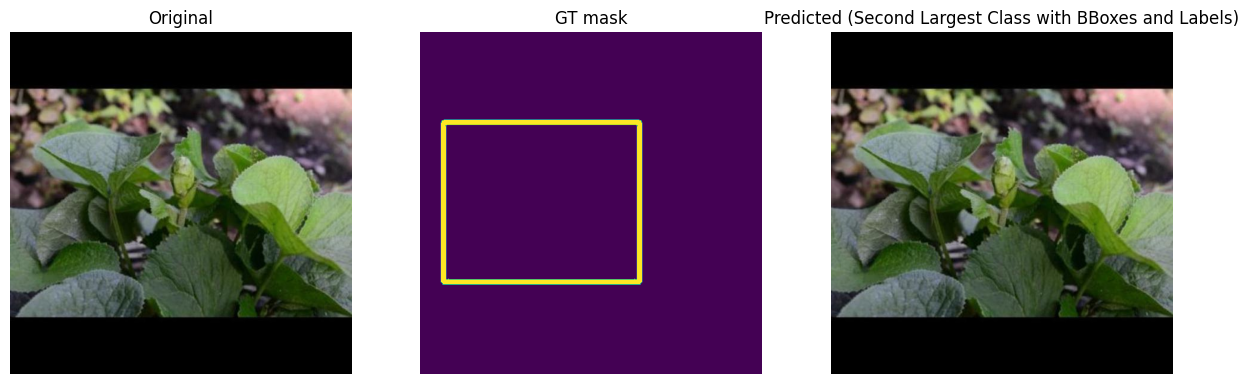

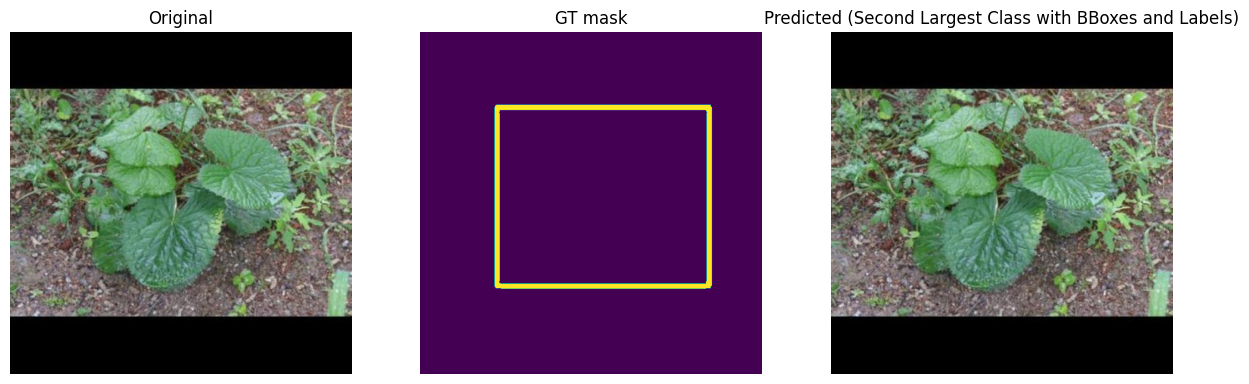

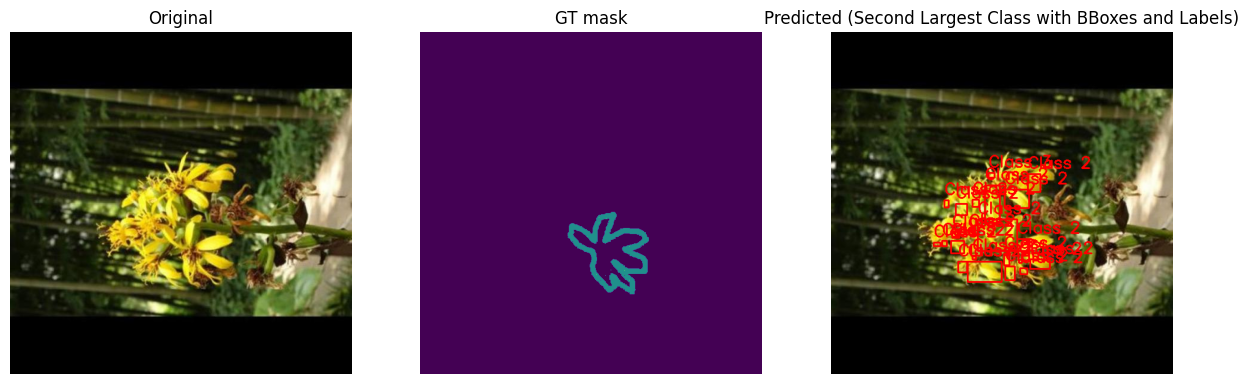

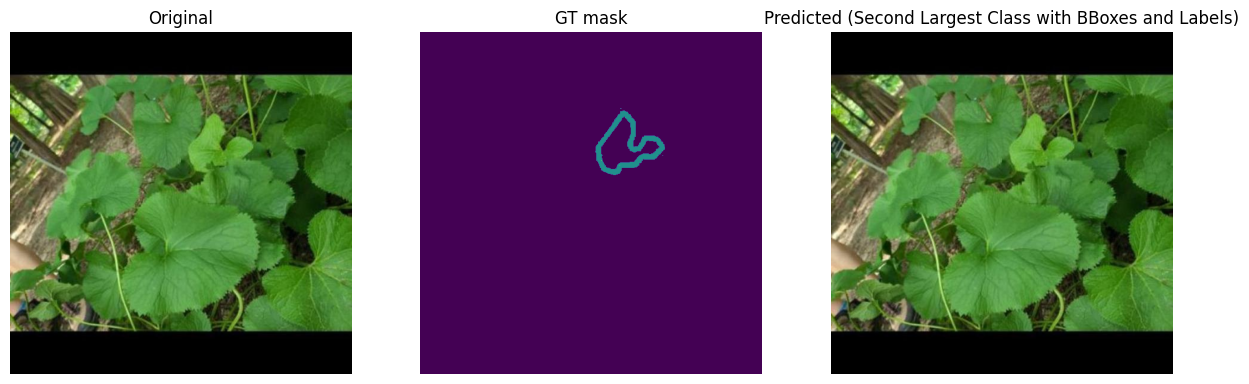

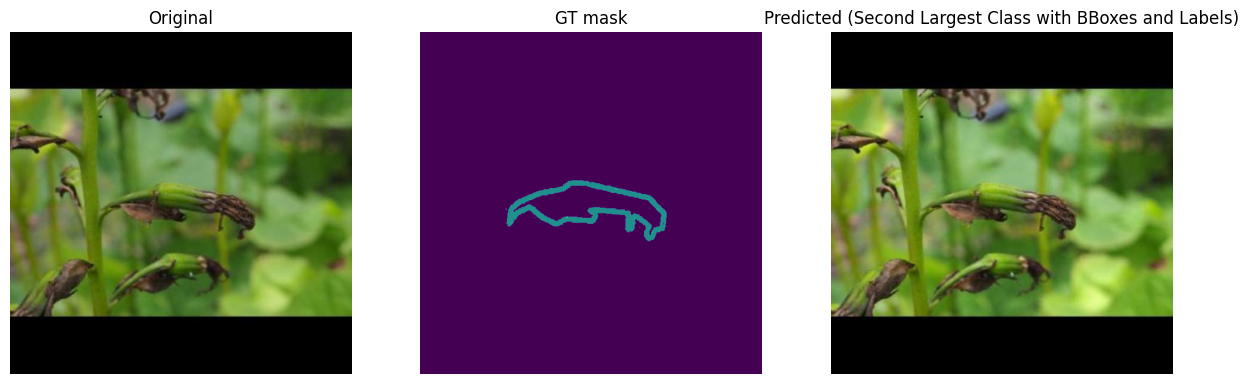

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2  # For bounding box operations
from tensorflow.keras.preprocessing import image

# Function to find bounding boxes and corresponding classes from the mask
import numpy as np
import cv2  # For bounding box operations

# Function to find bounding boxes and corresponding classes from the mask
def find_bboxes_and_classes(mask, class_pred):
    # Find contours (regions with non-zero values in the mask)
    contours, _ = cv2.findContours(mask.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bboxes_and_classes = []
    for contour in contours:
        # Get bounding box
        bbox = cv2.boundingRect(contour)
        x, y, w, h = bbox

        # Extract the class predictions for the region inside the bounding box
        region_classes = class_pred[y:y+h, x:x+w].flatten()

        if len(region_classes) > 0:  # Ensure the region is not empty
            # Find the most common class in this region
            region_class = np.bincount(region_classes).argmax()  # Most common class
            bboxes_and_classes.append((bbox, region_class))
        else:
            # Optionally, handle the empty region case (e.g., by skipping it)
            continue

    return bboxes_and_classes

# Function to draw bounding boxes and label the class
def draw_bboxes_with_labels(img, bboxes_and_classes):
    img_with_bboxes = np.copy(image.img_to_array(img)).astype('uint8')
    for bbox, class_label in bboxes_and_classes:
        x, y, w, h = bbox
        # Draw the bounding box (in red color for visibility)
        cv2.rectangle(img_with_bboxes, (x, y), (x + w, y + h), (255, 0, 0), 2)  # (B, G, R) color

        # Put class label at the top-left corner of the bounding box
        cv2.putText(img_with_bboxes, f'Class {class_label}', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)  # Red text
    return img_with_bboxes

# Visualizing random samples
for img_idx in random.sample(list(range(len(val_pred_second_largest))), 5):
    plt.figure(figsize=(15, 8))

    # Load original and ground truth images
    ori_img = image.load_img(valid_input_img_path[img_idx])
    target_img = image.load_img(target_valid[img_idx])
    target_mask = image.img_to_array(target_img)[:, :, 0] - 1

    # Get the second-largest class prediction mask
    mask = val_pred_second_largest[img_idx]

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.axis("off")
    plt.imshow(ori_img)

    plt.subplot(1, 3, 2)
    plt.title('GT mask')
    plt.axis("off")
    plt.imshow(target_mask)

    # Resize mask to match original image size
    resized_mask = resize_mask(mask, ori_img.size)

    # Optionally process the mask (e.g., morphological opening)
    processed_mask = opening(resized_mask)

    # Find bounding boxes and the most common class within each box
    bboxes_and_classes = find_bboxes_and_classes(processed_mask, val_pred_second_largest[img_idx])

    # Draw bounding boxes and labels on the original image
    img_with_bboxes = draw_bboxes_with_labels(ori_img, bboxes_and_classes)

    plt.subplot(1, 3, 3)
    plt.title('Predicted (Second Largest Class with BBoxes and Labels)')
    plt.axis("off")
    plt.imshow(image.array_to_img(img_with_bboxes))

    plt.show()


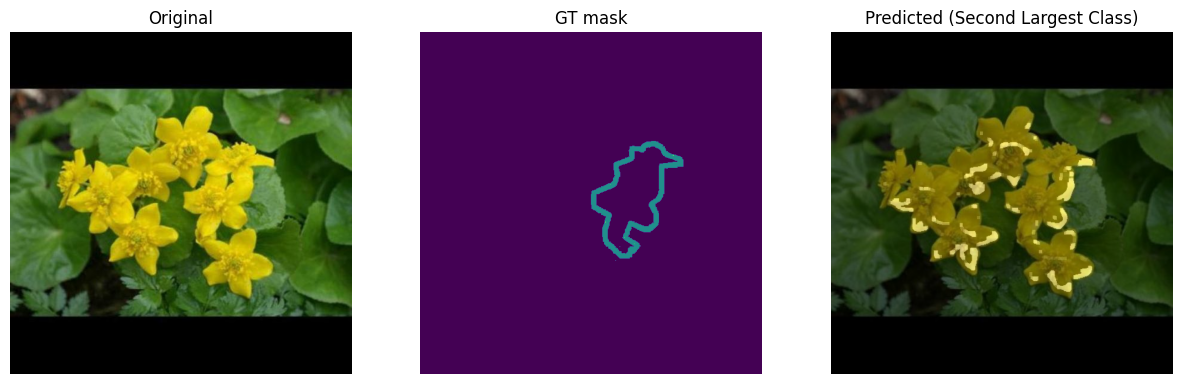

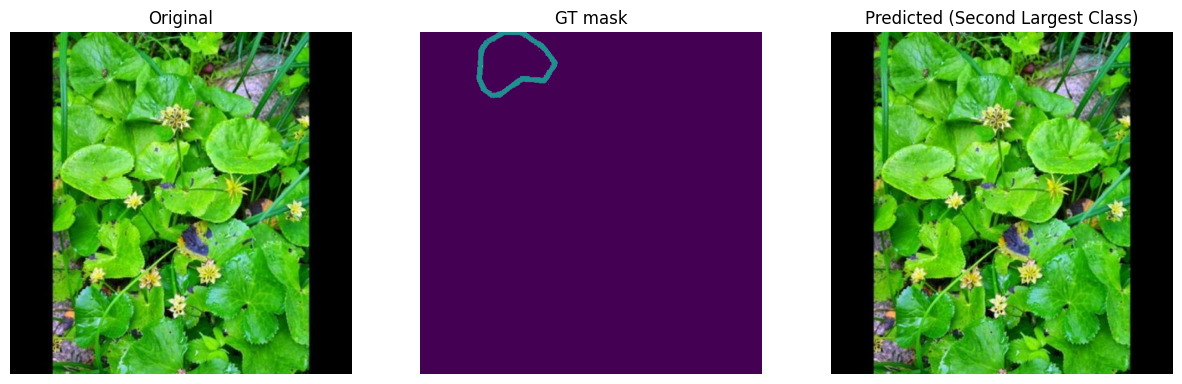

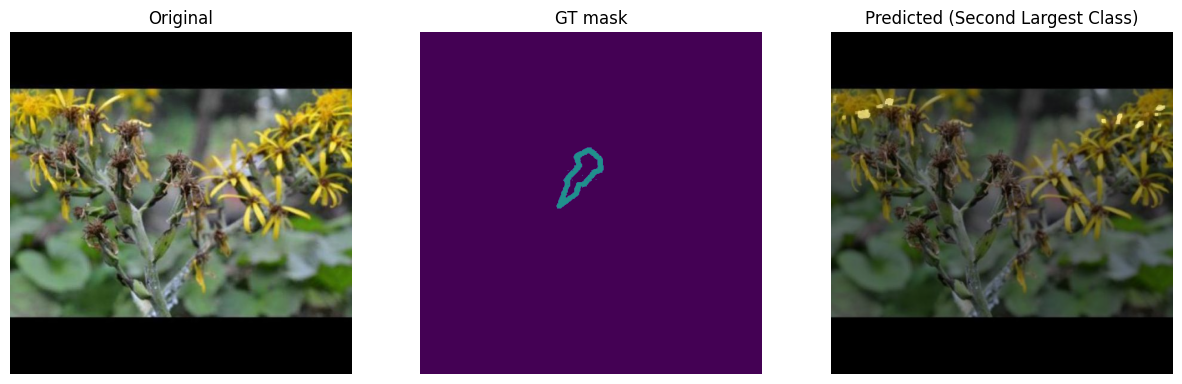

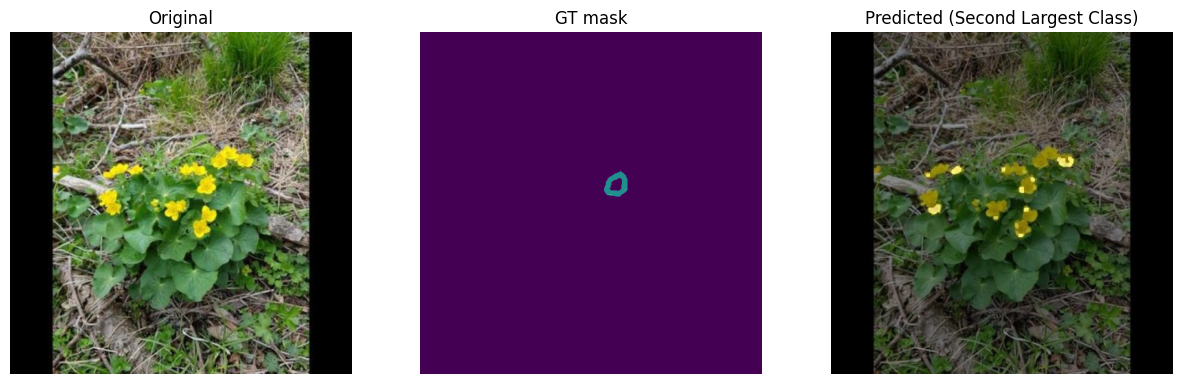

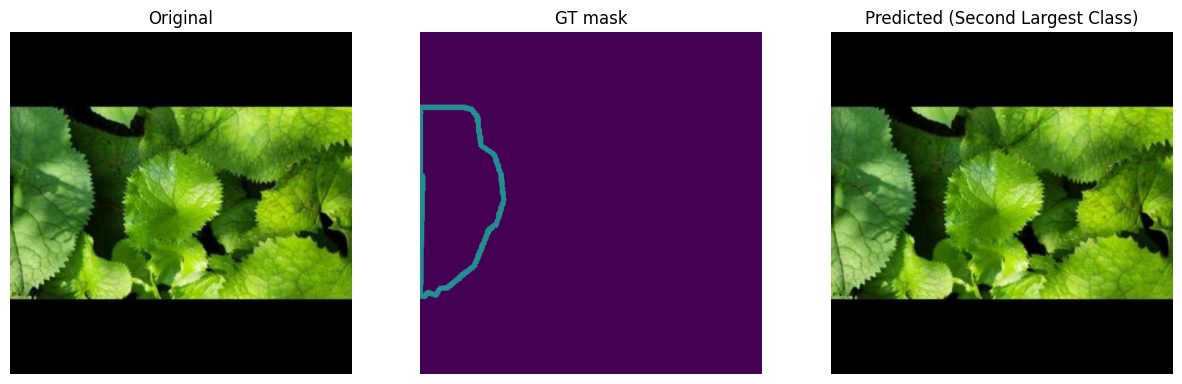

In [ ]:
import numpy as np

def resize_mask(mask, target_size):
    # Resize the mask (make sure it's a 2D mask, e.g., (512, 512))
    resized_mask = image.array_to_img(np.expand_dims(mask, axis=-1)).resize(target_size)
    return np.array(resized_mask)

def add_mask_to_img(img, mask):
    # Add logic to overlay the mask onto the original image
    # Assume mask is a 2D array, so expand its dimensions for the operation
    img_array = image.img_to_array(img)
    mask_3d = np.expand_dims(mask, axis=-1)  # Expanding to 3D for broadcasting
    mask_3d = np.repeat(mask_3d, 3, axis=-1)  # Repeat the mask across 3 channels (RGB)

    # Overlay mask on the image - here you can blend them or highlight masked regions
    overlay_img = img_array * 0.6 + mask_3d * 0.4  # Example blend
    return overlay_img

# Visualizing random samples
for img_idx in random.sample(list(range(len(val_pred_second_largest))), 5):
    plt.figure(figsize=(15, 8))

    # Load original and ground truth images
    ori_img = image.load_img(valid_input_img_path[img_idx])
    target_img = image.load_img(target_valid[img_idx])
    target_mask = image.img_to_array(target_img)[:, :, 0] - 1

    # Get the second-largest class prediction mask
    mask = val_pred_second_largest[img_idx]

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.axis("off")
    plt.imshow(ori_img)

    plt.subplot(1, 3, 2)
    plt.title('GT mask')
    plt.axis("off")
    plt.imshow(target_mask)

    # Resize mask to match original image size
    resized_mask = resize_mask(mask, ori_img.size)

    # Optionally process the mask (e.g., morphological opening)
    processed_mask = opening(resized_mask)

    # Apply mask to original image
    masked_img = add_mask_to_img(ori_img, processed_mask)

    plt.subplot(1, 3, 3)
    plt.title('Predicted (Second Largest Class)')
    plt.axis("off")
    plt.imshow(image.array_to_img(masked_img.astype('uint8')))

    plt.show()


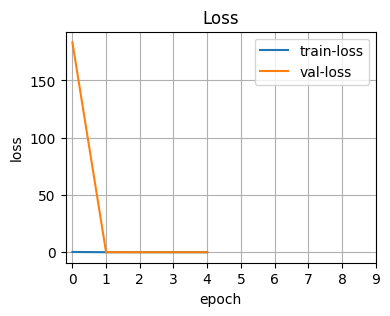

In [ ]:
history_unet = history.history

plt.figure(figsize=(4, 3))
plt.plot(history_unet['loss'], label='train-loss')
plt.plot(history_unet['val_loss'], label='val-loss')
plt.legend()
plt.grid()
plt.xticks(range(10))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")
plt.show()

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy",metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    )

model.fit(train_gen, epochs=5, validation_data=val_gen, verbose=2)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,1048576] vs. [1,11534336]
	 [[{{node LogicalAnd}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_192744[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_193049]

In [ ]:
def solution(s):
  result=[]
  tmp=[]
  for i in s:
    if len(tmp)==0:
      result.append(-1)
      tmp.append(i)
    else:
      if i in tmp:
        ind=  tmp.index(i)
        result(len(tmp)+1 - ind)
        tmp =[]
        tmp.append(i)
      else:
        tmp.append(i)
  return result

solution('banana')